# ARIMA | ARIMAX
This notebook outlines the ARIMA and ARIMAX implementation of the Bitcoin Price Prediction task. AutoRegressive Integrated Moving Average or ARIMA consists of three major components:
*  AR(p): Autoregressive , which is a measure of how much the past influences teh present.
*  I (d): How many times the data must be differneced to make it stationary (requirement).
*  MA (q): Moving Average: how much past erroneous predictions influence the current value.

These three components must be obtained and optimized for good peformance and this notebook outlines the attempts at applying this technique to the two Datasets created for Bitcoin Price Prediction. ARIMAX is also investigated to encorporate features such as twitter sentiment and Relative Strength Index.

Practical Resources Used:
*  [Practical Implementation Guide](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
*  [Implementation ](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
*  [Documentation]( https://www.statsmodels.org/stable/tsa.html)

In [ ]:
#installations
!pip install --upgrade numpy==1.25.2
!pip install --upgrade pmdarima
!pip install codecarbon

[codecarbon INFO @ 13:23:59] Energy consumed for RAM : 0.015748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:23:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:23:59] Energy consumed for All CPU : 0.066935 kWh
[codecarbon INFO @ 13:23:59] 0.082683 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:00] Energy consumed for RAM : 0.016206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:00] Energy consumed for All CPU : 0.068885 kWh
[codecarbon INFO @ 13:24:00] 0.085091 kWh of electricity used since the beginning.


In [ ]:
# Imports
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(
    output_file='emissions_arima.csv',
    project_name='arima_implementation') #,country_iso_code="IE"
tracker.start()

# neccessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime
from google.colab import drive
from google.colab import files
import sys
import joblib
import zipfile
import warnings
warnings.filterwarnings('ignore')
#seed for reproducibility
np.random.seed(42)



drive.mount('/content/drive', force_remount = True)
file_path = '/content/drive/My Drive/FILE_PATH #Replace FILE_PATH with the actual file destination or upload directly to notebook
#reading
df_1 = pd.read_csv(file_path + 'feature_engineered_data_1.csv', infer_datetime_format=True)
df_2 = pd.read_csv(file_path + 'feature_engineered_data_2.csv',infer_datetime_format=True)

#copy this file to the Colab Directory - alternatively: just download and upload directly
!cp '/content/drive/MyDrive/FILE_PATH/eval_metrics_cv.py' . #replace FILE_PATH with actual file path.
# Add the directory containing eval_metrics.py to the system path
sys.path.append('.')

from eval_metrics_cv import mae_calc, rmse_calc, smape_calc, rolling_cv

[codecarbon WARNING @ 13:24:13] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:24:13] [setup] RAM Tracking...
[codecarbon INFO @ 13:24:13] [setup] CPU Tracking...
[codecarbon INFO @ 13:24:14] Energy consumed for RAM : 0.015789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:14] Energy consumed for All CPU : 0.067112 kWh
[codecarbon INFO @ 13:24:14] 0.082902 kWh of electricity used since the beginning.
[codecarbon WARNING @ 13:24:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:24:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:24:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20G

Mounted at /content/drive


In [ ]:
#splitting the data, 90% training model and tuning, 5% test and refit, 5% for later final meta evaluation

#df_1
total_df_1_len = len(df_1)
train_df_1_len = int(0.9 * total_df_1_len)
refit_df_1_len = int(0.05 * total_df_1_len)
meta_df_1_len = int(0.05 * total_df_1_len)

#creating splits
train_df_1 = df_1.iloc[:train_df_1_len]
refit_df_1 = df_1.iloc[train_df_1_len:train_df_1_len + refit_df_1_len]
meta_df_1 = df_1.iloc[train_df_1_len + refit_df_1_len:]

#df_2
total_df_2_len = len(df_2)
train_df_2_len = int(0.9 * total_df_2_len)
refit_df_2_len = int(0.05 * total_df_2_len)
meta_df_2_len = int(0.05 * total_df_2_len)

#creating splits
train_df_2 = df_2.iloc[:train_df_2_len]
refit_df_2 = df_2.iloc[train_df_2_len:train_df_2_len + refit_df_2_len]
meta_df_2 = df_2.iloc[train_df_2_len + refit_df_2_len:]

In [ ]:
#making sure dataframes are in the correct formar for arima - datetime index
train_df_1 = train_df_1.copy()
refit_df_1 = refit_df_1.copy()
train_df_2 = train_df_2.copy()
refit_df_2 = refit_df_2.copy()
train_df_1['Time_UTC'] = pd.to_datetime(train_df_1['Time_UTC'])
refit_df_1['Time_UTC'] = pd.to_datetime(refit_df_1['Time_UTC'])
#meta_df_1['Time_UTC'] = pd.to_datetime(meta_df_1['Time_UTC'])
train_df_2['Time_UTC'] = pd.to_datetime(train_df_2['Time_UTC'])
refit_df_2['Time_UTC'] = pd.to_datetime(refit_df_2['Time_UTC'])

series_train_1 = train_df_1.set_index('Time_UTC')['Close_UTC_00']
series_train_2 = train_df_2.set_index('Time_UTC')['Close_UTC_00']
series_refit_1 = refit_df_1.set_index('Time_UTC')['Close_UTC_00']
series_refit_2 = refit_df_2.set_index('Time_UTC')['Close_UTC_00']

ARIMA and ARIMAX expects stationarity in the data and according to the literture refered to, perfroming an ADF test will decide whether the data needs to be converted to stationary data.

In [ ]:
#define target and exog columns for each
target_col = 'Close_UTC_00'
exog_cols_1 = ['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
exog_cols_2 = ['avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']

# creating target column
y_train_1 = series_train_1
y_train_2 = series_train_2
y_refit_1 = series_refit_1
y_refit_2 = series_refit_2

# x columns for arimax
x_train_1 = train_df_1[exog_cols_1]
x_train_2 = train_df_2[exog_cols_2]
x_refit_1 = refit_df_1[exog_cols_1]
x_refit_2 = refit_df_2[exog_cols_2]

In [ ]:
#define target and exog columns for each
target_col = 'Close_UTC_00'
exog_cols_1 = ['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
exog_cols_2 = ['avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']

# creating target column
y_train_1 = series_train_1
y_train_2 = series_train_2
y_refit_1 = series_refit_1
y_refit_2 = series_refit_2

# x columns for arimax
x_train_1 = train_df_1[exog_cols_1]
x_train_2 = train_df_2[exog_cols_2]
x_refit_1 = refit_df_1[exog_cols_1]
x_refit_2 = refit_df_2[exog_cols_2]#peforming the adf test on the various datasets above
#check stationary

#train data df_1
print('Results of Dickey-Fuller Test Train_df_1:')
adf_result_1 = adfuller(y_train_1)
print(f"ADF Statistic: {adf_result_1[0]:.4f}")
print(f"p-value: {adf_result_1[1]:.4f}")

stationary = adf_result_1[1] < 0.05
print(f"Series is stationary? {stationary}")


#refit data df_1
print('Results of Dickey-Fuller Test Refit_df_1:')
adf_result_1_refit = adfuller(y_refit_1)
print(f"ADF Statistic: {adf_result_1_refit[0]:.4f}")
print(f"p-value: {adf_result_1_refit[1]:.4f}")

stationary = adf_result_1_refit[1] < 0.05
print(f"Series is stationary? {stationary}")

#train data df_2
print('Results of Dickey-Fuller Test Train_df_2:')
adf_result_2 = adfuller(y_train_2)
print(f"ADF Statistic: {adf_result_2[0]:.4f}")
print(f"p-value: {adf_result_2[1]:.4f}")

stationary = adf_result_2[1] < 0.05
print(f"Series is stationary? {stationary}")

#refit data df_2
print('Results of Dickey-Fuller Test Refit_df_2:')
adf_result_2_refit = adfuller(y_refit_2)
print(f"ADF Statistic: {adf_result_2_refit[0]:.4f}")
print(f"p-value: {adf_result_2_refit[1]:.4f}")

stationary = adf_result_2_refit[1] < 0.05
print(f"Series is stationary? {stationary}")

Results of Dickey-Fuller Test Train_df_1:
ADF Statistic: 0.3738
p-value: 0.9805
Series is stationary? False
Results of Dickey-Fuller Test Refit_df_1:
ADF Statistic: -1.6813
p-value: 0.4408
Series is stationary? False
Results of Dickey-Fuller Test Train_df_2:
ADF Statistic: -1.0556
p-value: 0.7325
Series is stationary? False
Results of Dickey-Fuller Test Refit_df_2:
ADF Statistic: 3.9660
p-value: 1.0000
Series is stationary? False


Apply Differencing

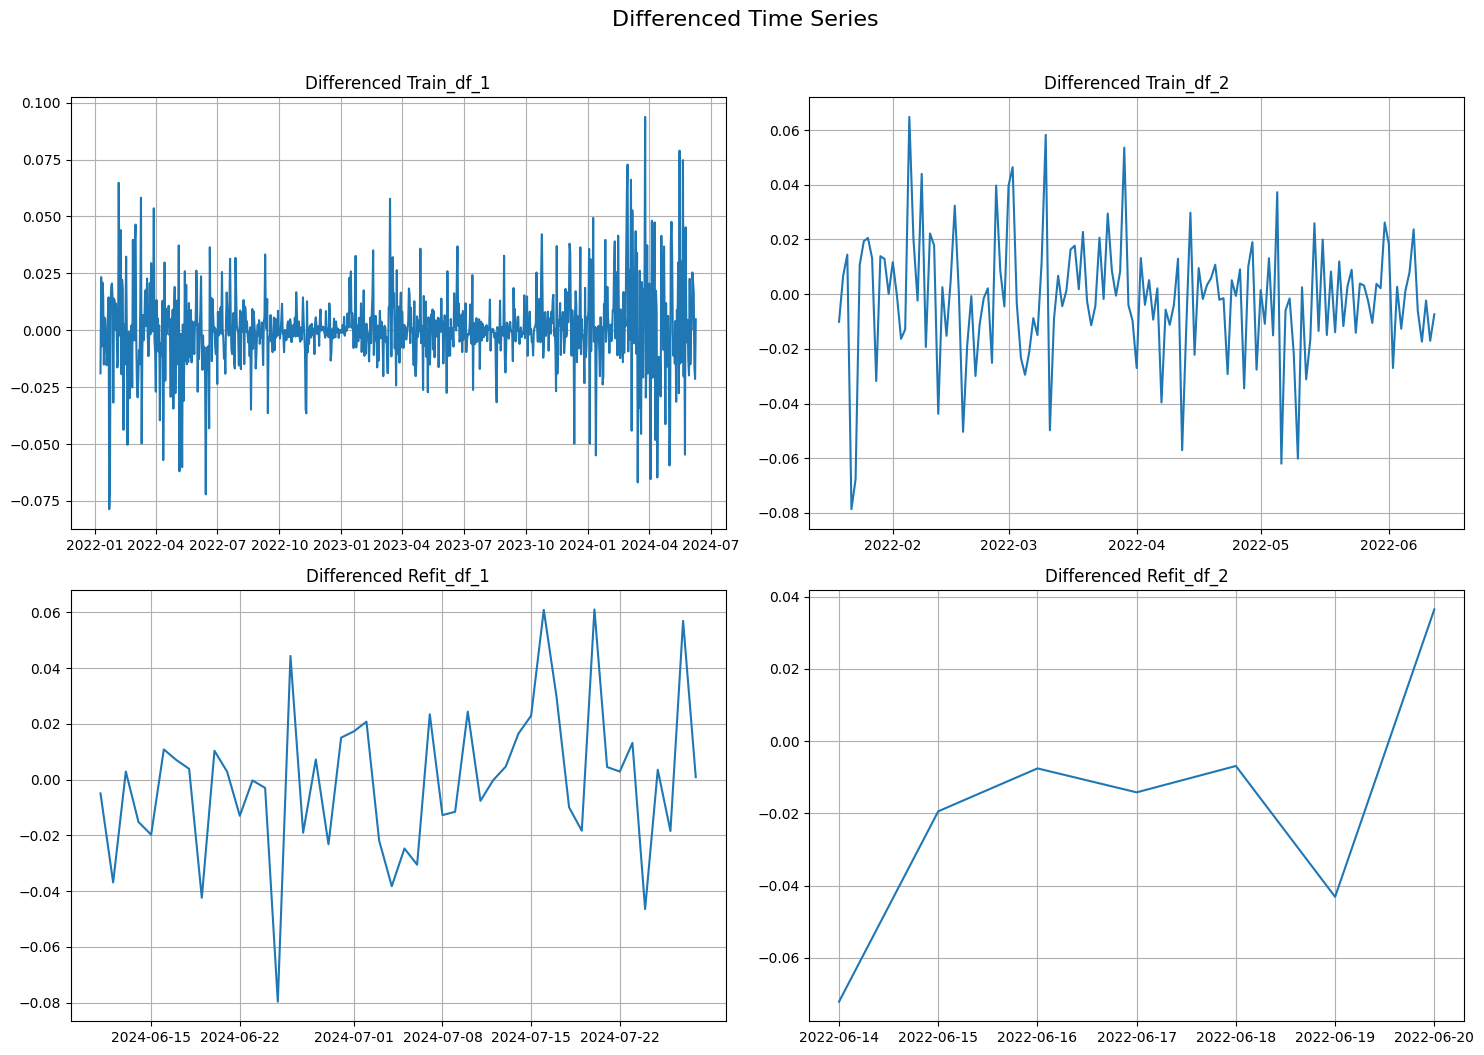

In [ ]:
# creating target column
diff_series_train_1 = y_train_1.diff().dropna()
diff_series_train_2 = y_train_2.diff().dropna()
diff_series_refit_1 = y_refit_1.diff().dropna()
diff_series_refit_2 = y_refit_2.diff().dropna()

#plotting the four on a subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=False)

#plot each
axs[0, 0].plot(diff_series_train_1)
axs[0, 0].set_title('Differenced Train_df_1')
axs[0,0].grid(True)

axs[0, 1].plot(diff_series_train_2)
axs[0, 1].set_title('Differenced Train_df_2')
axs[0,1].grid(True)

axs[1, 0].plot(diff_series_refit_1)
axs[1, 0].set_title('Differenced Refit_df_1')
axs[1,0].grid(True)

axs[1, 1].plot(diff_series_refit_2)
axs[1, 1].set_title('Differenced Refit_df_2')
axs[1,1].grid(True)

plt.tight_layout()
plt.suptitle('Differenced Time Series', fontsize=16, y=1.05)
plt.show()

In [ ]:
#applying the adf test to each again

#df1
print('Results of Dickey-Fuller Test Train_df_1:')
adf_result_1 = adfuller(diff_series_train_1)
print(f"ADF Statistic: {adf_result_1[0]:.4f}")
print(f"p-value: {adf_result_1[1]:.4f}")
stationary = adf_result_1[1] < 0.05
print(f"Series is stationary? {stationary}")

#df_1 resit
print('Results of Dickey-Fuller Test Refit_df_1:')
adf_result_1_refit = adfuller(diff_series_refit_1)
print(f"ADF Statistic: {adf_result_1_refit[0]:.4f}")
print(f"p-value: {adf_result_1_refit[1]:.4f}")
stationary = adf_result_1_refit[1] < 0.05
print(f"Series is stationary? {stationary}")

#df2
print('Results of Dickey-Fuller Test Train_df_2:')
adf_result_2 = adfuller(diff_series_train_2)
print(f"ADF Statistic: {adf_result_2[0]:.4f}")
print(f"p-value: {adf_result_2[1]:.4f}")
stationary = adf_result_2[1] < 0.05
print(f"Series is stationary? {stationary}")

#df2 resit
print('Results of Dickey-Fuller Test Refit_df_2:')
adf_result_2_refit = adfuller(diff_series_refit_2)
print(f"ADF Statistic: {adf_result_2_refit[0]:.4f}")
print(f"p-value: {adf_result_2_refit[1]:.4f}")
stationary = adf_result_2_refit[1] < 0.05
print(f"Series is stationary? {stationary}")


Results of Dickey-Fuller Test Train_df_1:
ADF Statistic: -20.4898
p-value: 0.0000
Series is stationary? True
Results of Dickey-Fuller Test Refit_df_1:
ADF Statistic: -7.2907
p-value: 0.0000
Series is stationary? True
Results of Dickey-Fuller Test Train_df_2:
ADF Statistic: -12.0472
p-value: 0.0000
Series is stationary? True
Results of Dickey-Fuller Test Refit_df_2:
ADF Statistic: -2.7121
p-value: 0.0720
Series is stationary? False


we will have to difference that again

In [ ]:
#df_2 refit
diff_diff_series_refit_2 = diff_series_refit_2.diff().dropna()
#checking again
print('Results of Dickey-Fuller Test Refit_df_2:')
adf_result_2_refit = adfuller(diff_diff_series_refit_2)
print(f"ADF Statistic: {adf_result_2_refit[0]:.4f}")
print(f"p-value: {adf_result_2_refit[1]:.4f}")
stationary = adf_result_2_refit[1] < 0.05
print(f"Series is stationary? {stationary}")

Results of Dickey-Fuller Test Refit_df_2:
ADF Statistic: -33.6534
p-value: 0.0000
Series is stationary? True


Auto and Partial Autocorrelation Functions are also investigated to get an initial idea for the q,p and d numbers for both datasets.

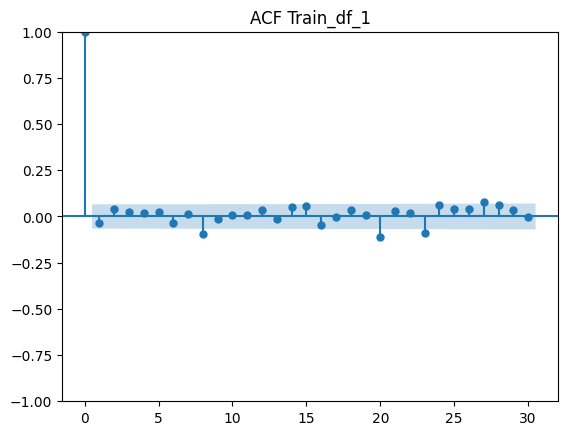

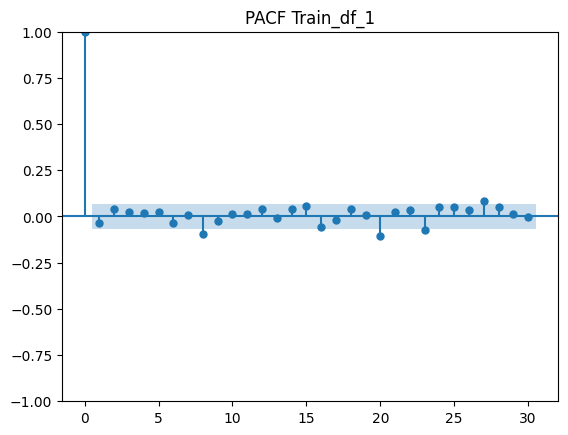

In [ ]:
#plotting acf abd pacf for each
plot_acf(diff_series_train_1, lags=30)
plt.title('ACF Train_df_1')
plt.show()

plot_pacf(diff_series_train_1, lags=30)
plt.title('PACF Train_df_1')
plt.show()



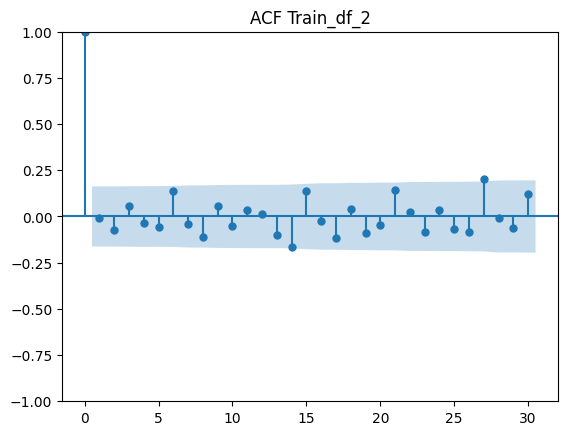

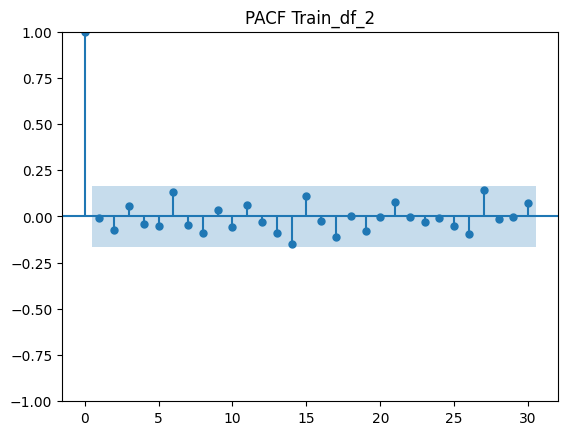

In [ ]:
#plotting acf abd pacf for each
plot_acf(diff_series_train_2, lags=30)
plt.title('ACF Train_df_2')
plt.show()

plot_pacf(diff_series_train_2, lags=30)
plt.title('PACF Train_df_2')
plt.show()


#Auto-model Tuning
The above investaigations give an indication that differencing is definitely needed and likely a low value for PACF. We will now look at auto_model to determine optimal p,q and d values.

In [ ]:
#using autoarima to find best parameters
#optimizing arima model
max_p=5
max_q=5
max_d=2
auto_model = auto_arima(y_train_1,
                        start_p=0, max_p=max_p,
                        start_q=0, max_q=max_q,
                        start_d=0, max_d=max_d,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        n_jobs=-1)

best_order = auto_model.order
print(f"\nBest Order: {best_order}")
print(f"AIC: {auto_model.aic():.4f}")

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3934.384, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4230.615, Time=0.50 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3936.383, Time=0.61 sec


[codecarbon INFO @ 13:24:29] Energy consumed for RAM : 0.015831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:29] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:29] Energy consumed for All CPU : 0.067290 kWh
[codecarbon INFO @ 13:24:29] 0.083121 kWh of electricity used since the beginning.


 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-4337.323, Time=1.30 sec


[codecarbon INFO @ 13:24:30] Energy consumed for RAM : 0.016290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:30] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:30] Energy consumed for All CPU : 0.069240 kWh
[codecarbon INFO @ 13:24:30] 0.085529 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:30] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:30] Delta energy consumed for CPU with constant : 0.000179 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:30] Energy consumed for All CPU : 0.000179 kWh
[codecarbon INFO @ 13:24:30] 0.000221 kWh of electricity used since the beginning.


 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-4391.049, Time=1.72 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-4426.561, Time=5.04 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-4437.594, Time=5.33 sec


[codecarbon INFO @ 13:24:44] Energy consumed for RAM : 0.015873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:44] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:44] Energy consumed for All CPU : 0.067468 kWh
[codecarbon INFO @ 13:24:44] 0.083341 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:45] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:45] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:45] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 13:24:45] 0.000439 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:45] Energy consumed for RAM : 0.016331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:45] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:45] Energy consumed for All CPU : 0.069417 kWh
[codecarbon INFO @ 13:24:45] 0.085749 kWh 

 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-4522.351, Time=15.17 sec


[codecarbon INFO @ 13:24:59] Energy consumed for RAM : 0.015915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:24:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:24:59] Energy consumed for All CPU : 0.067645 kWh
[codecarbon INFO @ 13:24:59] 0.083560 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:00] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:00] Energy consumed for All CPU : 0.000533 kWh
[codecarbon INFO @ 13:25:00] 0.000658 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:00] Energy consumed for RAM : 0.016373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:00] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:00] Energy consumed for All CPU : 0.069595 kWh
[codecarbon INFO @ 13:25:00] 0.085968 kWh 

 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-4500.491, Time=10.97 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=-4518.102, Time=1.40 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.97 sec


[codecarbon INFO @ 13:25:14] Energy consumed for RAM : 0.015956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:14] Energy consumed for All CPU : 0.067823 kWh
[codecarbon INFO @ 13:25:14] 0.083779 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:15] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:15] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:15] Energy consumed for All CPU : 0.000710 kWh
[codecarbon INFO @ 13:25:15] 0.000877 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:15] Energy consumed for RAM : 0.016415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:15] Delta energy consumed for CPU with constant : 0.000179 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:15] Energy consumed for All CPU : 0.069774 kWh
[codecarbon INFO @ 13:25:15] 0.086189 kWh 

 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-4555.955, Time=3.75 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-4556.480, Time=1.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-4428.560, Time=0.38 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=1.61 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-4393.048, Time=0.49 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=1.23 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-4439.594, Time=0.43 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=-4560.145, Time=1.91 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=-4554.844, Time=2.99 sec


[codecarbon INFO @ 13:25:29] Energy consumed for RAM : 0.015998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:29] Energy consumed for All CPU : 0.067999 kWh
[codecarbon INFO @ 13:25:29] 0.083997 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:29] 0.003185 g.CO2eq/s mean an estimation of 100.4354880673103 kg.CO2eq/year
[codecarbon INFO @ 13:25:30] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:30] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:30] Energy consumed for All CPU : 0.000887 kWh
[codecarbon INFO @ 13:25:30] 0.001095 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:30] Energy consumed for RAM : 0.016456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:30] Delta energy consumed for CPU with constant : 0.000175 kWh, power : 42.5 W
[codecarbon 

 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=3.96 sec

Best model:  ARIMA(5,2,2)(0,0,0)[0]          
Total fit time: 69.486 seconds

Best Order: (5, 2, 2)
AIC: -4560.1449


In [ ]:
#df2
#using autoarima to find best parameters
#optimizing arima model
max_p=5
max_q=5
max_d=2
auto_model = auto_arima(y_train_2,
                        start_p=0, max_p=max_p,
                        start_q=0, max_q=max_q,
                        start_d=0, max_d=max_d,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        n_jobs=-1)

best_order = auto_model.order
print(f"\nBest Order: {best_order}")
print(f"AIC: {auto_model.aic():.4f}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-678.192, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-676.208, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-676.211, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-679.456, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-674.454, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.505 seconds

Best Order: (0, 1, 0)
AIC: -679.4559


Best Order: (0, 0, 0)
AIC: -679.4559

In [ ]:
#arimax
#using autoarima to find best parameters
#optimizing arima model
max_p=5
max_q=5
max_d=2
auto_model = auto_arima(y_train_1, exogenous=x_train_1,
                        start_p=0, max_p=max_p,
                        start_q=0, max_q=max_q,
                        start_d=0, max_d=max_d,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        n_jobs=-1)

best_order = auto_model.order
print(f"\nBest Order: {best_order}")
print(f"AIC: {auto_model.aic():.4f}")

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3934.384, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4230.615, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3936.383, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-4337.323, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-4391.049, Time=0.24 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-4426.561, Time=1.63 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-4437.594, Time=1.01 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-4522.351, Time=3.03 sec


[codecarbon INFO @ 13:25:44] Energy consumed for RAM : 0.016040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:44] Energy consumed for All CPU : 0.068177 kWh
[codecarbon INFO @ 13:25:44] 0.084217 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:45] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:45] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 13:25:45] 0.001313 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:45] Energy consumed for RAM : 0.016498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:45] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:45] Energy consumed for All CPU : 0.070125 kWh
[codecarbon INFO @ 13:25:45] 0.086622 kWh 

 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-4500.491, Time=5.63 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=-4518.102, Time=1.35 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-4555.955, Time=1.40 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-4556.480, Time=1.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-4428.560, Time=0.39 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=1.99 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-4393.048, Time=2.17 sec


[codecarbon INFO @ 13:25:59] Energy consumed for RAM : 0.016081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:25:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:25:59] Energy consumed for All CPU : 0.068354 kWh
[codecarbon INFO @ 13:25:59] 0.084436 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:00] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:26:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:26:00] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 13:26:00] 0.001532 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:00] Energy consumed for RAM : 0.016539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:26:00] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 13:26:00] Energy consumed for All CPU : 0.070301 kWh
[codecarbon INFO @ 13:26:00] 0.086839 kWh 

 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=2.69 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-4439.594, Time=0.78 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=-4560.145, Time=1.94 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=-4554.844, Time=1.86 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=1.75 sec

Best model:  ARIMA(5,2,2)(0,0,0)[0]          
Total fit time: 34.753 seconds

Best Order: (5, 2, 2)
AIC: -4560.1449


In [ ]:
#arimax
#using autoarima to find best parameters
#optimizing arima model
max_p=5
max_q=5
max_d=2
auto_model = auto_arima(y_train_2, exogenous=x_train_2,
                        start_p=0, max_p=max_p,
                        start_q=0, max_q=max_q,
                        start_d=0, max_d=max_d,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        n_jobs=-1)

best_order = auto_model.order
print(f"\nBest Order: {best_order}")
print(f"AIC: {auto_model.aic():.4f}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-678.192, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-676.208, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-676.211, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-679.456, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-674.454, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.547 seconds

Best Order: (0, 1, 0)
AIC: -679.4559


As the structure of ARIMA/ARIMAX is inherently different to the other model implementations, the rolling_cv is recreated below with the ARIMA sturcture in mind. This can then be used with the best parameters as determined above to train the best model.

The following orders were determined and can be used going forward:
* ARIMA Train_df_1: (5,2,2)
* ARIMA Train_df_2: (0,1,0)
* ARIMAX Train_df_1: (5,2,2)
* ARIMA Train_df_2: (0,1,0)

In [ ]:
def arima_rolling_cv(y, order, n_splits=5):
  tscv = TimeSeriesSplit(n_splits=n_splits)
  mae_list, rmse_list, smape_list = [], [], []

  for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #model
    model = ARIMA(y_train, order=order)
    model_fit = model.fit()
    y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1])


    #calculating results
    mae = mae_calc(y_test, y_pred)
    rmse = rmse_calc(y_test, y_pred)
    smape = smape_calc(y_test, y_pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    smape_list.append(smape)

  return {
      'mae': np.mean(mae_list),
      'rmse': np.mean(rmse_list),
      'smape': np.mean(smape_list)
  }


In [ ]:
#df_1
results_arima_1 = arima_rolling_cv(y_train_1, order=(5, 2, 2), n_splits=5)
print(results_arima_1)

[codecarbon INFO @ 13:26:14] Energy consumed for RAM : 0.016123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:26:14] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 13:26:14] Energy consumed for All CPU : 0.068531 kWh
[codecarbon INFO @ 13:26:14] 0.084654 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:15] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:26:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:26:15] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 13:26:15] 0.001750 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:15] 0.003181 g.CO2eq/s mean an estimation of 100.30427539966071 kg.CO2eq/year
[codecarbon INFO @ 13:26:15] Energy consumed for RAM : 0.016580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:26:15] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon

{'mae': 0.11200872366194917, 'rmse': 0.13900388205420133, 'smape': 61.66902343207973}


In [ ]:
results_arima_2 = arima_rolling_cv(y_train_2, order=(0, 1, 0), n_splits=5)
print(results_arima_2)

{'mae': 0.05791624573993116, 'rmse': 0.07038268232390196, 'smape': 14.693432576129371}


MAE: 0 4
RMSE: 0 4
SMAPE: 18 4


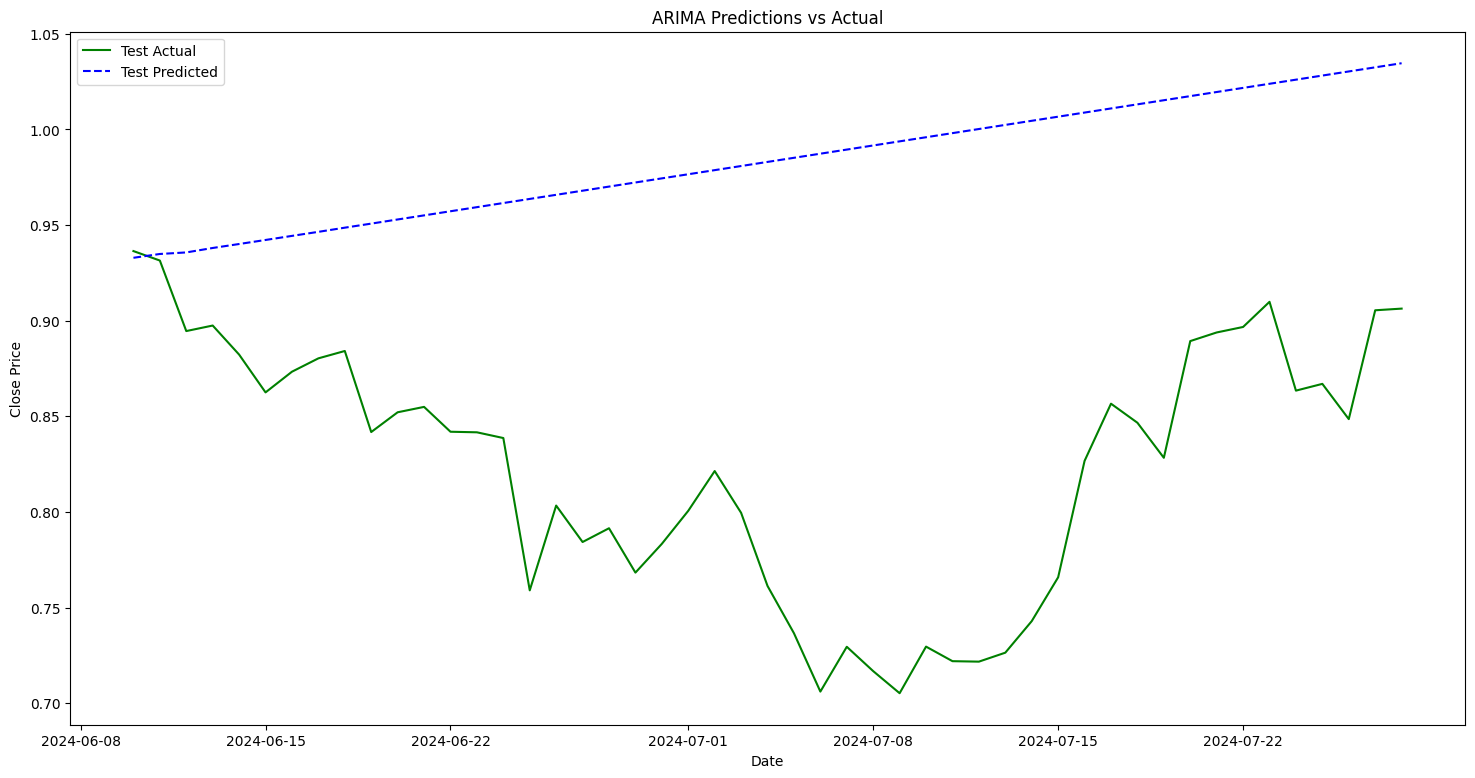

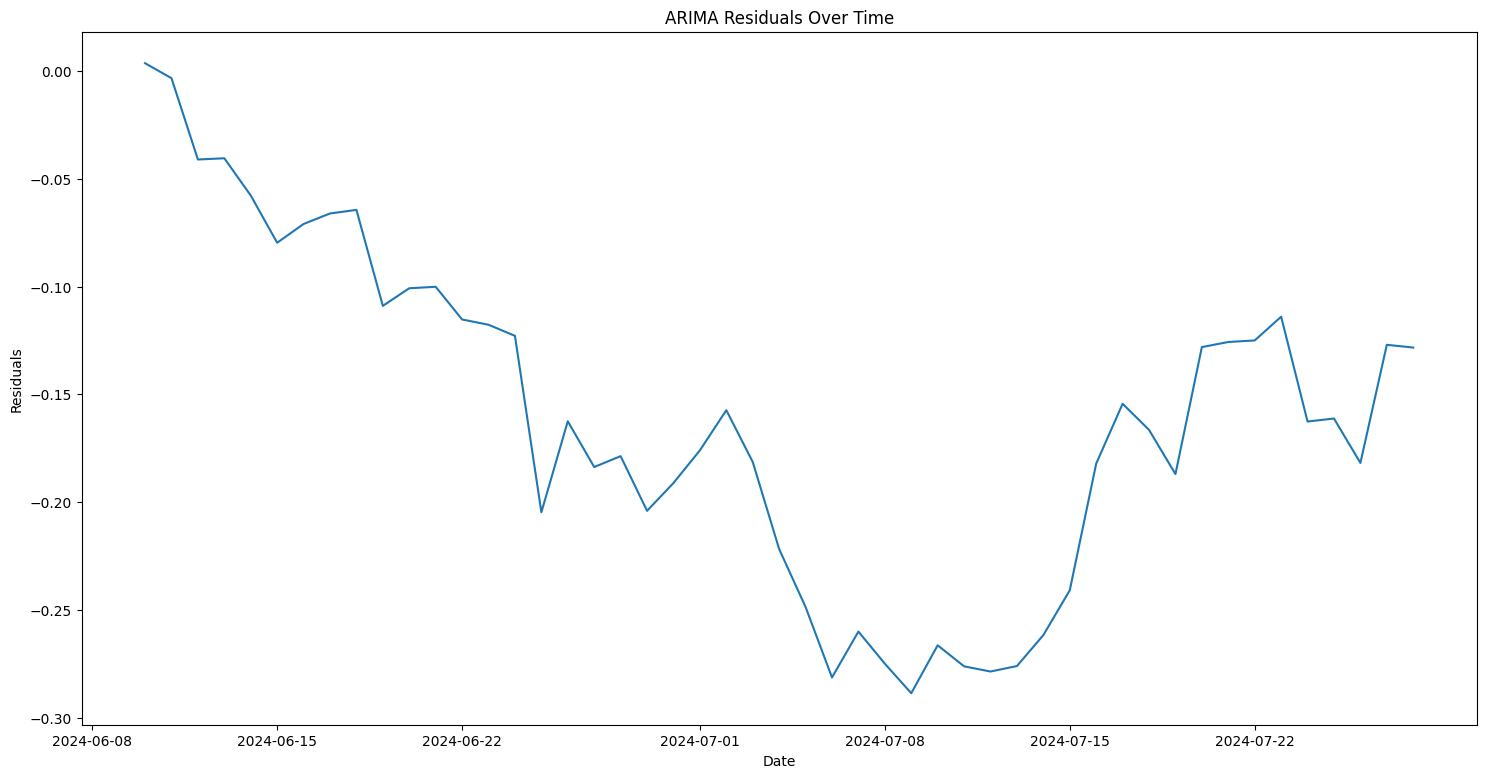

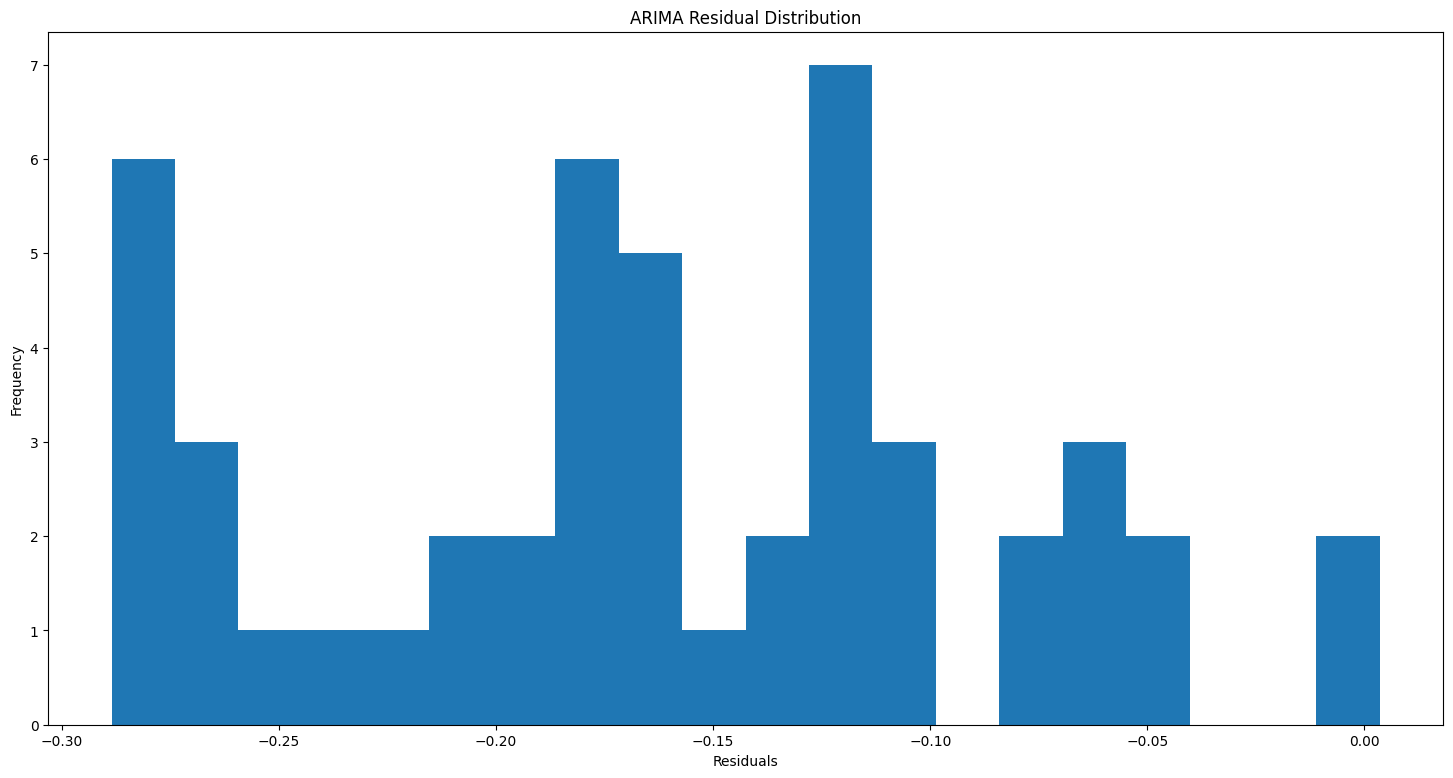

<Figure size 1800x900 with 0 Axes>

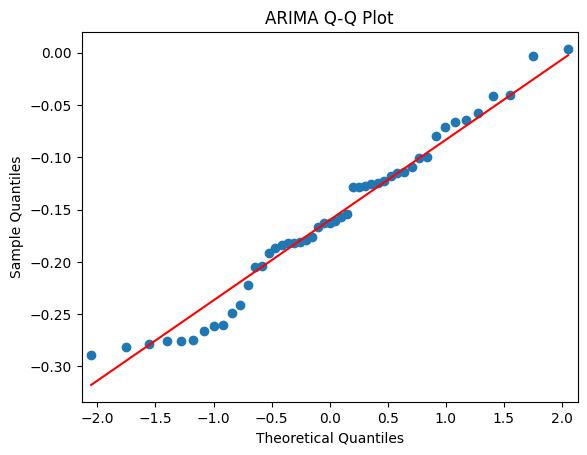

       lb_stat     lb_pvalue
1    41.307466  1.300711e-10
2    74.837573  5.613420e-17
3   102.505839  4.493974e-22
4   124.973008  4.625275e-26
5   142.936985  4.248608e-29
6   156.806772  2.809047e-31
7   166.077554  1.684443e-32
8   171.277144  6.963030e-33
9   173.843550  9.756514e-33
10  175.246014  2.270508e-32


In [ ]:
#fitting final model and testing on refit data
final_model_arima_1 = ARIMA(y_train_1, order=(5, 2, 2))
final_model_arima_1_fit = final_model_arima_1.fit()

#y_train_pred = final_model_arima_1_fit.predict(start=y_train_1.index[0], end=y_train_1.index[-1])
#predicting on refit
y_pred_arima_1 = final_model_arima_1_fit.predict(start=y_refit_1.index[0], end=y_refit_1.index[-1])
y_pred_arima_1.index = y_refit_1.index #allign to future index

#evaluate
print("MAE:", round(mae_calc(y_refit_1, y_pred_arima_1)), 4)
print("RMSE:", round(rmse_calc(y_refit_1, y_pred_arima_1)), 4)
print("SMAPE:", round(smape_calc(y_refit_1, y_pred_arima_1)), 4)

#visualize
#plot train and test results
plt.figure(figsize=(18,9))
plt.plot(y_refit_1.index, y_refit_1, 'g-', label='Test Actual')
plt.plot(y_refit_1.index, y_pred_arima_1, 'b--', label='Test Predicted')
plt.title('ARIMA Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


#residual analysis and visualisation
residuals_1 = y_refit_1 - y_pred_arima_1
plt.figure(figsize=(18,9))
plt.plot(residuals_1)
plt.title('ARIMA Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

#residula distribution
plt.figure(figsize=(18,9))
plt.hist(residuals_1, bins=20)
plt.title('ARIMA Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#q-q plot
plt.figure(figsize=(18,9))
sm.qqplot(residuals_1, line='s')
plt.title('ARIMA Q-Q Plot')
plt.show()

#checking the randomness of residuals
lb_test_1 = acorr_ljungbox(residuals_1, lags=10, return_df=True)
print(lb_test_1)

In [ ]:
#saving details
refit_results_1 ={
    'model_name': 'ARIMA',
    'order': (5, 2, 2),
    'eval_metrics':{
        'mae': round(mae_calc(y_refit_1, y_pred_arima_1), 4),
        'rmse': round(rmse_calc(y_refit_1, y_pred_arima_1), 4),
        'smape': round(smape_calc(y_refit_1, y_pred_arima_1), 4)
    },
    'ljung_bix': lb_test_1.to_dict(),
    'model': final_model_arima_1_fit
}
model_filename_1= 'refit_results_arima_1.pkl'
with open(model_filename_1, 'wb') as f:
    joblib.dump(refit_results_1, f)

model_filename_1_1 = 'final_model_arima_1.pkl'
with open(model_filename_1_1, 'wb') as f:
    joblib.dump(final_model_arima_1_fit, f)

MAE: 0 4
RMSE: 0 4
SMAPE: 79 4


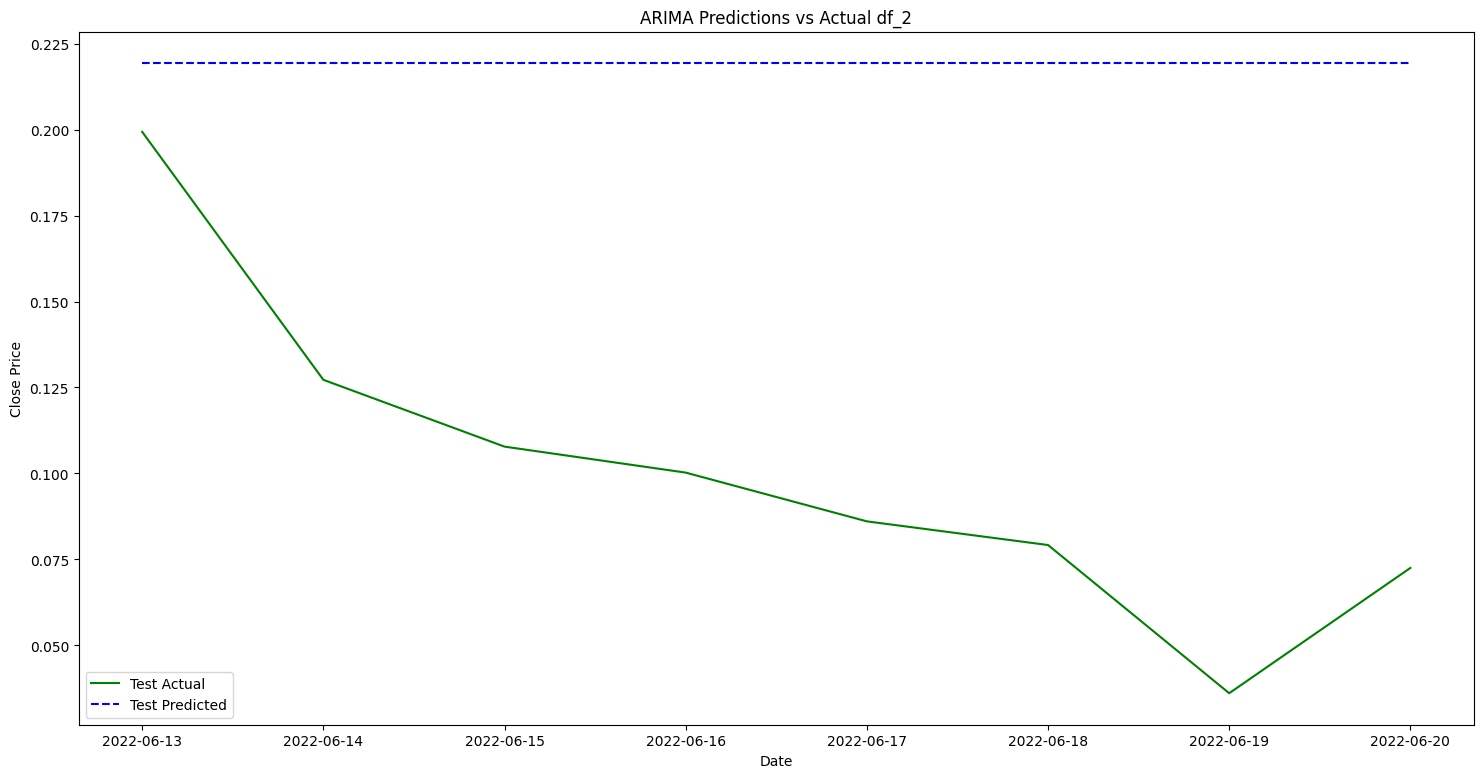

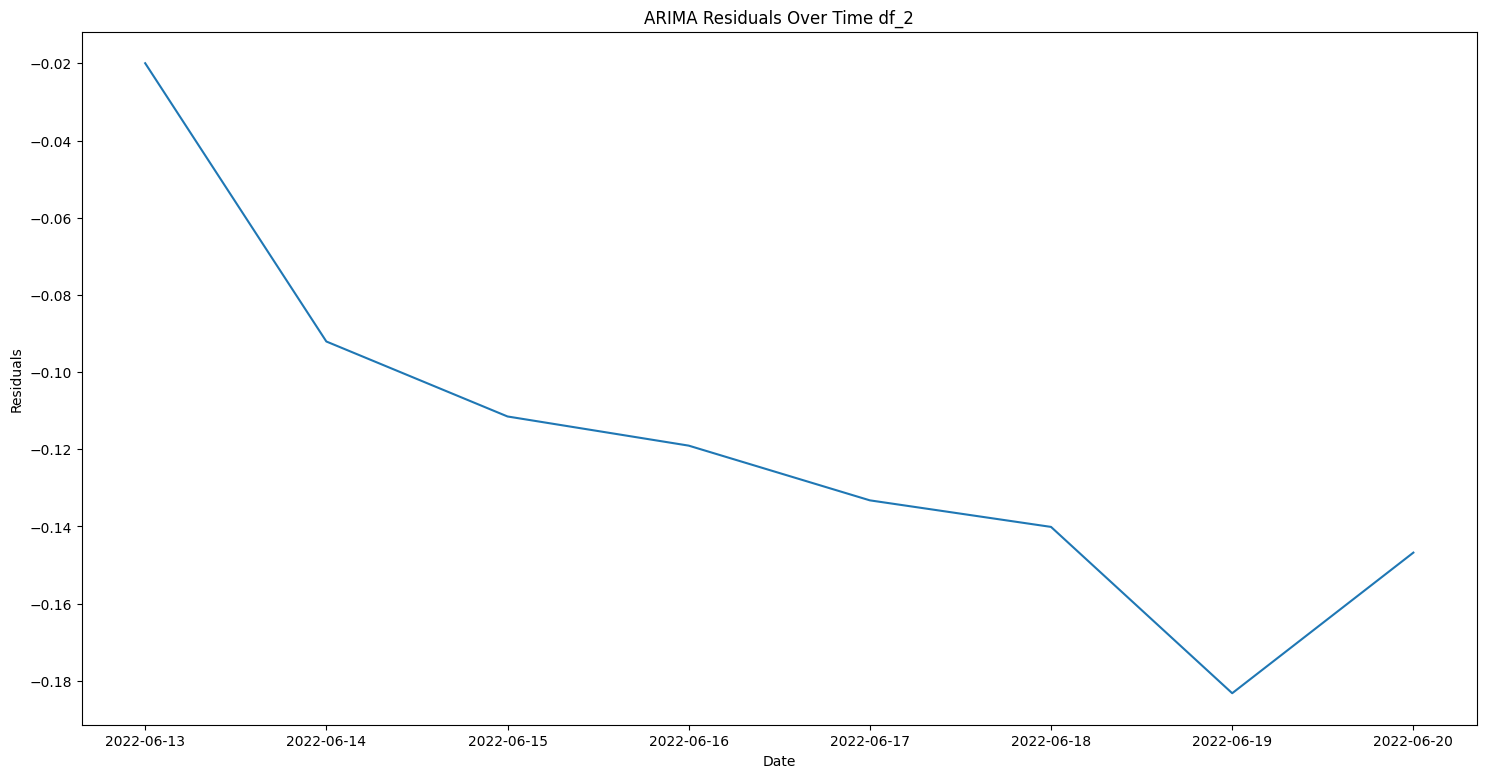

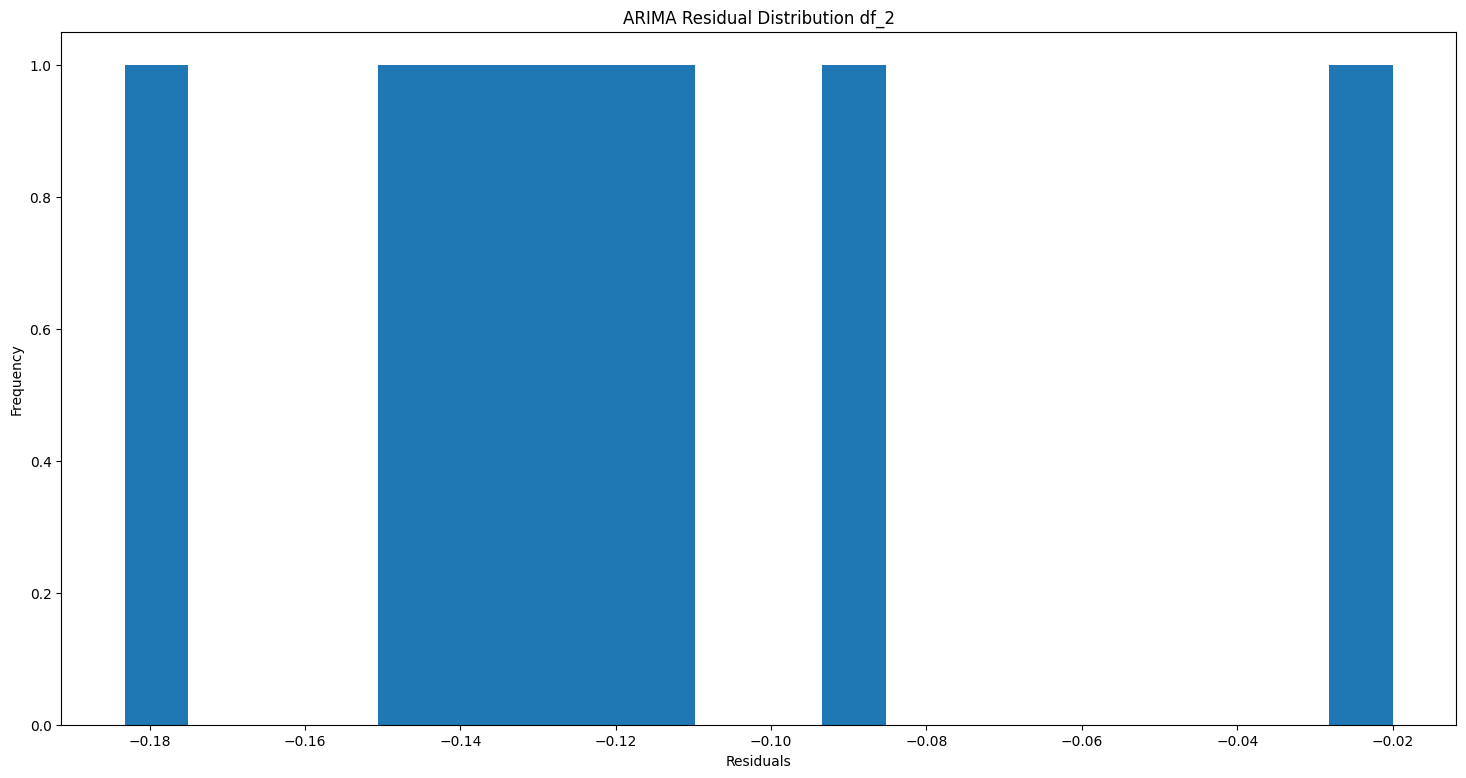

<Figure size 1800x900 with 0 Axes>

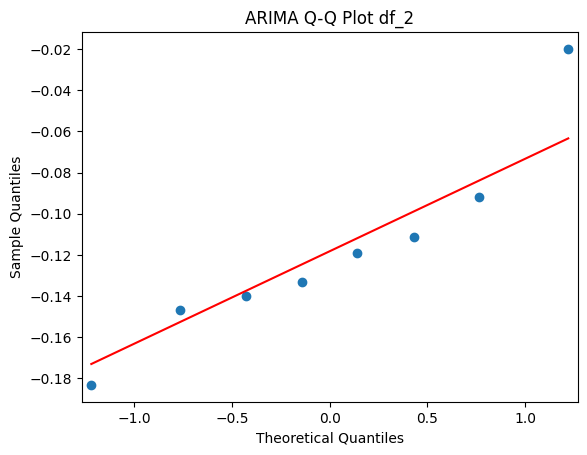

     lb_stat  lb_pvalue
1   1.776081   0.182631
2   2.014406   0.365239
3   2.015595   0.569176
4   2.481145   0.648015
5   4.156322   0.527136
6  11.978017   0.062461


In [ ]:
#fitting final model and testing on refit data
final_model_arima_2 = ARIMA(y_train_2, order=(0, 1, 0))
final_model_arima_2_fit = final_model_arima_2.fit()


#predicting on refit
y_pred_arima_2 = final_model_arima_2_fit.predict(start=y_refit_2.index[0], end=y_refit_2.index[-1])
y_pred_arima_2.index = y_refit_2.index #allign to future index

#evaluate
print("MAE:", round(mae_calc(y_refit_2, y_pred_arima_2)), 4)
print("RMSE:", round(rmse_calc(y_refit_2, y_pred_arima_2)), 4)
print("SMAPE:", round(smape_calc(y_refit_2, y_pred_arima_2)), 4)

#visualize
#plot train and test results
plt.figure(figsize=(18,9))
plt.plot(y_refit_2.index, y_refit_2, 'g-', label='Test Actual')
plt.plot(y_refit_2.index, y_pred_arima_2, 'b--', label='Test Predicted')
plt.title('ARIMA Predictions vs Actual df_2')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


#residual analysis and visualisation
residuals_2 = y_refit_2 - y_pred_arima_2
plt.figure(figsize=(18,9))
plt.plot(residuals_2)
plt.title('ARIMA Residuals Over Time df_2')
plt.xlabel('Date')
plt.ylabel('Residuals')

#residula distribution
plt.figure(figsize=(18,9))
plt.hist(residuals_2, bins=20)
plt.title('ARIMA Residual Distribution df_2')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#q-q plot
plt.figure(figsize=(18,9))
sm.qqplot(residuals_2, line='s')
plt.title('ARIMA Q-Q Plot df_2')
plt.show()

#checking the randomness of residuals
lb_test_2 = acorr_ljungbox(residuals_2, lags=min(10, len(residuals_2)-2), return_df=True)
print(lb_test_2)


#saving details
refit_results_2 ={
    'model_name': 'ARIMA',
    'order': (0, 1, 0),
    'eval_metrics':{
        'mae': round(mae_calc(y_refit_2, y_pred_arima_2), 4),
        'rmse': round(rmse_calc(y_refit_2, y_pred_arima_2), 4),
        'smape': round(smape_calc(y_refit_2, y_pred_arima_2), 4)
    },
    'ljung_bix': lb_test_2.to_dict(),
    'model': final_model_arima_2_fit
}
model_filename = 'refit_results_arima_2.pkl'
with open(model_filename, 'wb') as f:
    joblib.dump(refit_results_2, f)

model_filename_2 = 'final_model_arima_2.pkl'
with open(model_filename_2, 'wb') as f:
    joblib.dump(final_model_arima_2_fit, f)

In [ ]:
#same but for arimax
def arimax_rolling_cv(y, X, order, n_splits=5):
  tscv = TimeSeriesSplit(n_splits=n_splits)
  mae_list, rmse_list, smape_list = [], [], []

  for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    #ensuring same index
    X_train = X_train.set_index(y_train.index)

    #fitting model
    model = ARIMA(y_train, exog=X_train, order=order)
    model_fit = model.fit()
    y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

    #EVAL
    mae = mae_calc(y_test, y_pred)
    rmse = rmse_calc(y_test, y_pred)
    smape = smape_calc(y_test, y_pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    smape_list.append(smape)

    return {
      'mae': np.mean(mae_list),
      'rmse': np.mean(rmse_list),
      'smape': np.mean(smape_list)
  }

In [ ]:
#df1
results_arimax_1 = arimax_rolling_cv(y_train_1, X=x_train_1, order=(5, 2, 2), n_splits=5)
print(results_arimax_1)

{'mae': 0.1791694436736149, 'rmse': 0.2168388262647023, 'smape': 138.20251749174054}


[codecarbon INFO @ 13:31:14] Energy consumed for RAM : 0.016956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:31:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:31:14] Energy consumed for All CPU : 0.072072 kWh
[codecarbon INFO @ 13:31:14] 0.089028 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:31:15] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:31:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:31:15] Energy consumed for All CPU : 0.004958 kWh
[codecarbon INFO @ 13:31:15] 0.006124 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:31:15] Energy consumed for RAM : 0.017414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:31:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:31:15] Energy consumed for All CPU : 0.074019 kWh
[codecarbon INFO @ 13:31:15] 0.091432 kWh 

MAE: 0.2592
RMSE: 0.2892
SMAPE: 27.0578


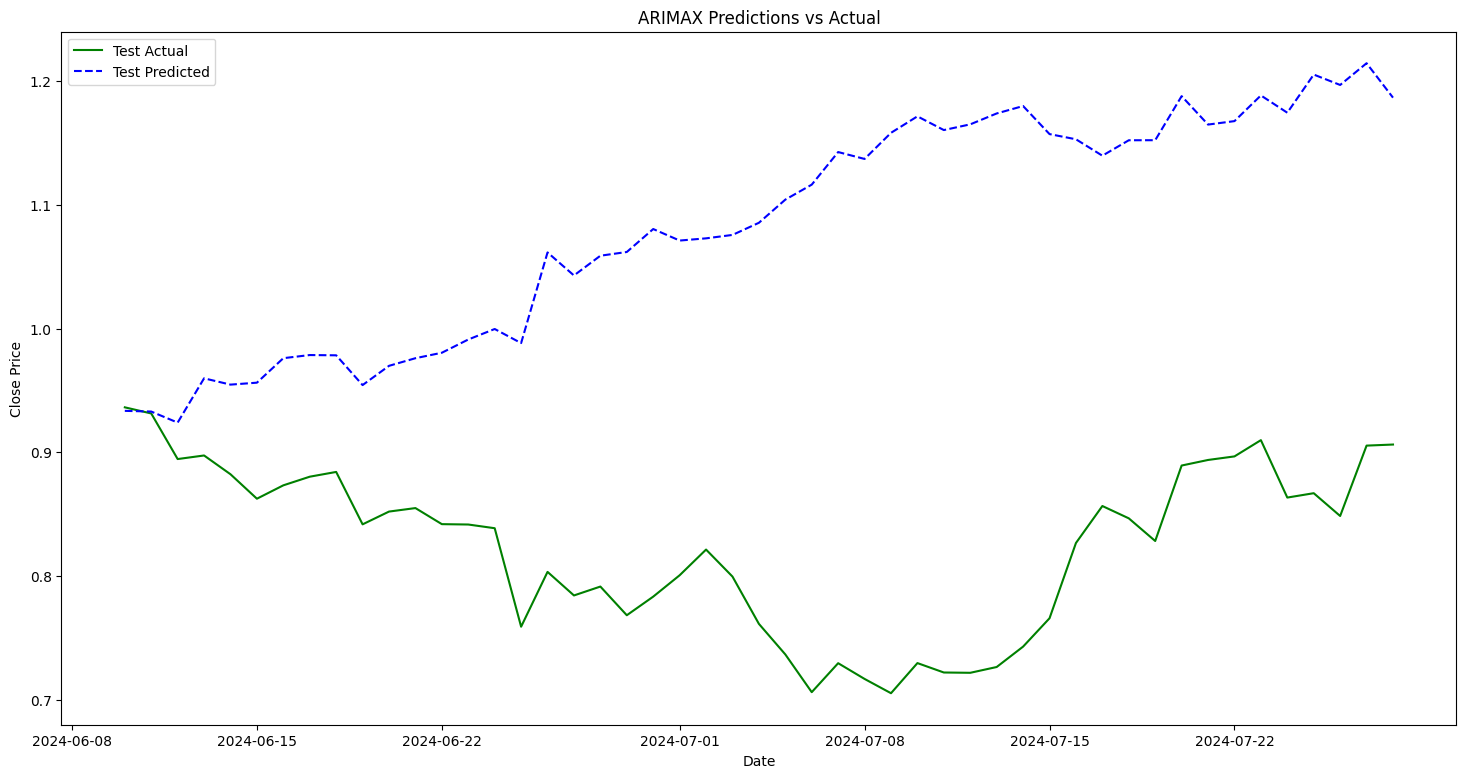

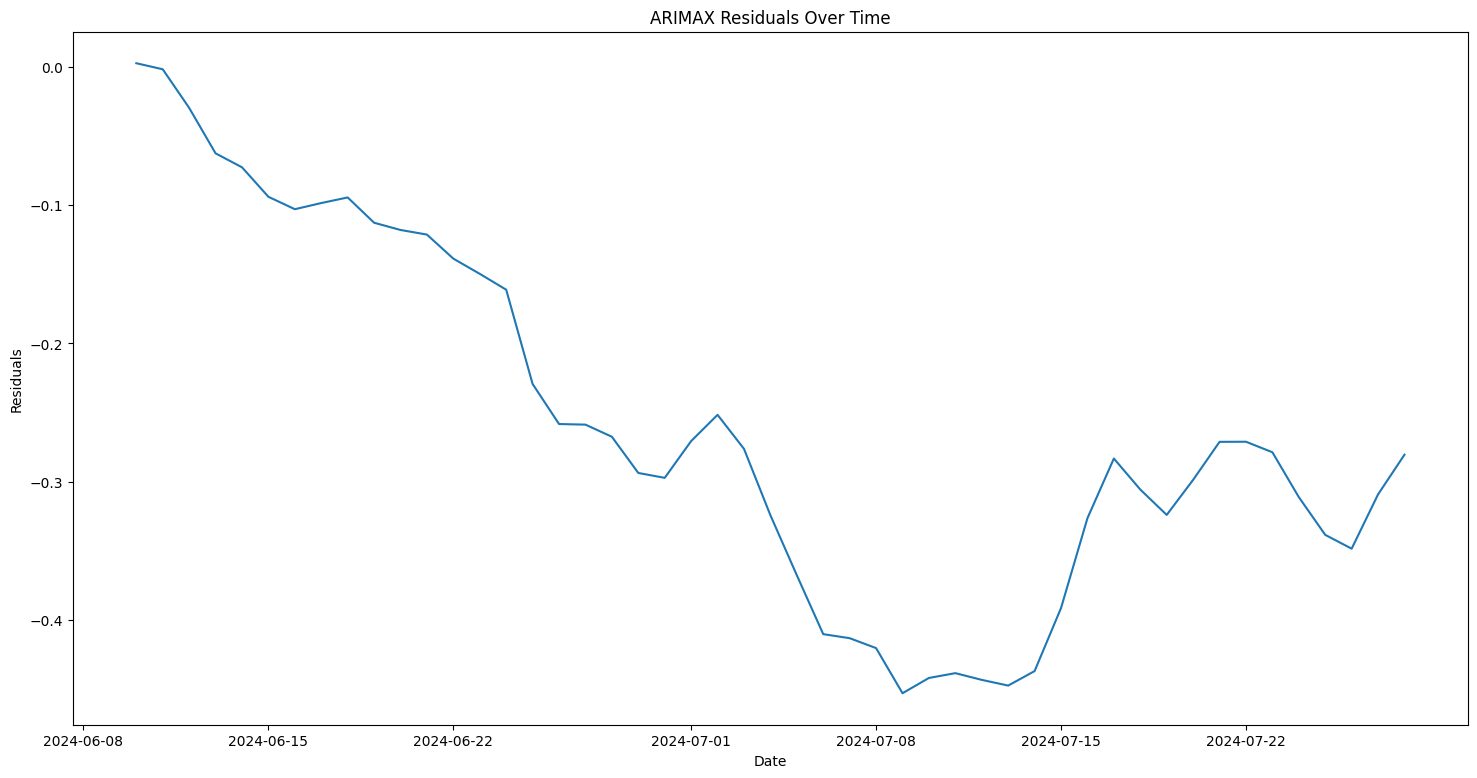

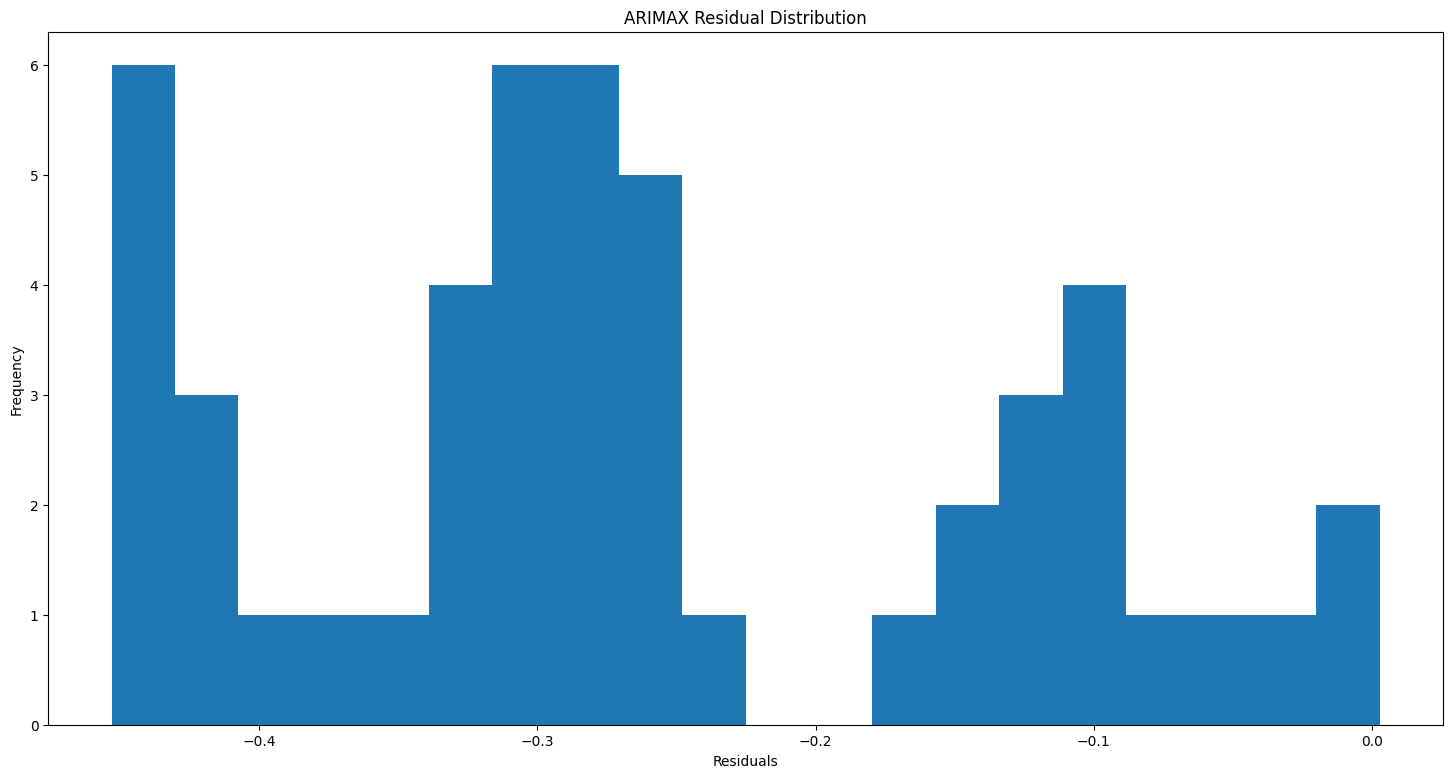

<Figure size 1800x900 with 0 Axes>

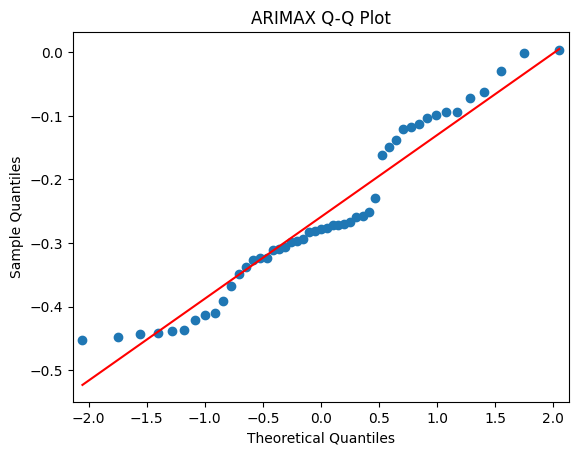

       lb_stat     lb_pvalue
1    45.682530  1.390574e-11
2    84.223438  5.141771e-19
3   116.576031  4.214634e-25
4   144.052058  3.827990e-30
5   167.018719  3.155656e-34
6   185.922797  1.871956e-37
7   200.916353  7.341570e-40
8   212.265769  1.655027e-41
9   220.487722  1.652633e-42
10  226.254327  5.236539e-43


In [ ]:
#ensuring same index
x_train_1 = x_train_1.set_index(y_train_1.index)

final_model_arimax_1 = ARIMA(y_train_1, exog=x_train_1, order=(5, 2, 2))
final_model_arimax_1_fit = final_model_arimax_1.fit()

y_pred_arimax_1 = final_model_arimax_1_fit.predict(
    start=y_refit_1.index[0],
    end=y_refit_1.index[-1],
    exog=x_refit_1
    )
y_pred_arimax_1.index = y_refit_1.index

#evaluating
print("MAE:", round(mae_calc(y_refit_1, y_pred_arimax_1), 4))
print("RMSE:", round(rmse_calc(y_refit_1, y_pred_arimax_1), 4))
print("SMAPE:", round(smape_calc(y_refit_1, y_pred_arimax_1), 4))

plt.figure(figsize=(18,9))
plt.plot(y_refit_1.index, y_refit_1, 'g-', label='Test Actual')
plt.plot(y_refit_1.index, y_pred_arimax_1, 'b--', label='Test Predicted')
plt.title('ARIMAX Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#residuals
residuals_1 = y_refit_1 - y_pred_arimax_1
plt.figure(figsize=(18,9))
plt.plot(residuals_1)
plt.title('ARIMAX Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

#distribution
plt.figure(figsize=(18,9))
plt.hist(residuals_1, bins=20)
plt.title('ARIMAX Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#qq-plot
plt.figure(figsize=(18,9))
sm.qqplot(residuals_1, line='s')
plt.title('ARIMAX Q-Q Plot')
plt.show()

#residual check
lb_test_1 = acorr_ljungbox(residuals_1, lags=10, return_df=True)
print(lb_test_1)

#save
refit_results__arimax_1={
    'model_name': 'ARIMAX',
    'order': (5, 2,2),
    'eval_metrics':{
        'mae': round(mae_calc(y_refit_1, y_pred_arimax_1), 4),
        'rmse': round(rmse_calc(y_refit_1, y_pred_arimax_1), 4),
        'smape': round(smape_calc(y_refit_1, y_pred_arimax_1), 4)
    },
    'ljung_bix': lb_test_1.to_dict(),
    'model': final_model_arimax_1_fit
}

#save both
model_filename_1 = 'refit_results_arimax_1.pkl'
with open(model_filename_1, 'wb') as f:
    joblib.dump(refit_results__arimax_1, f)

model_filename_1_1 = 'final_model_arimax_1.pkl'
with open(model_filename_1_1, 'wb') as f:
    joblib.dump(final_model_arimax_1_fit, f)

In [ ]:
#df2
results_arimax_2 = arimax_rolling_cv(y_train_2, X=x_train_2, order=(0, 1, 0), n_splits=5)

print(results_arimax_2)

{'mae': 0.07317863195009532, 'rmse': 0.08092525486753029, 'smape': 19.46540253753363}


MAE: 0.0369
RMSE: 0.0432
SMAPE: 37.8608


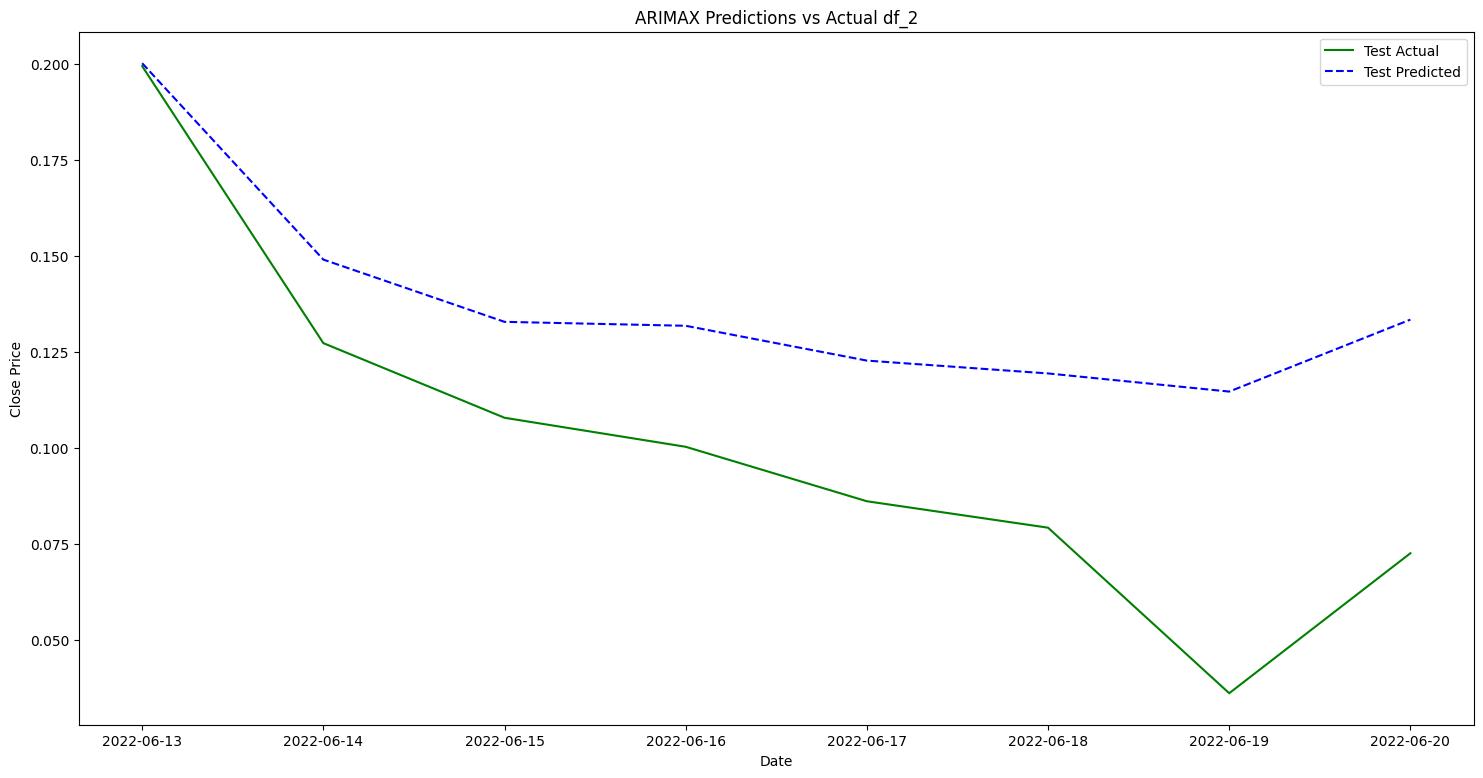

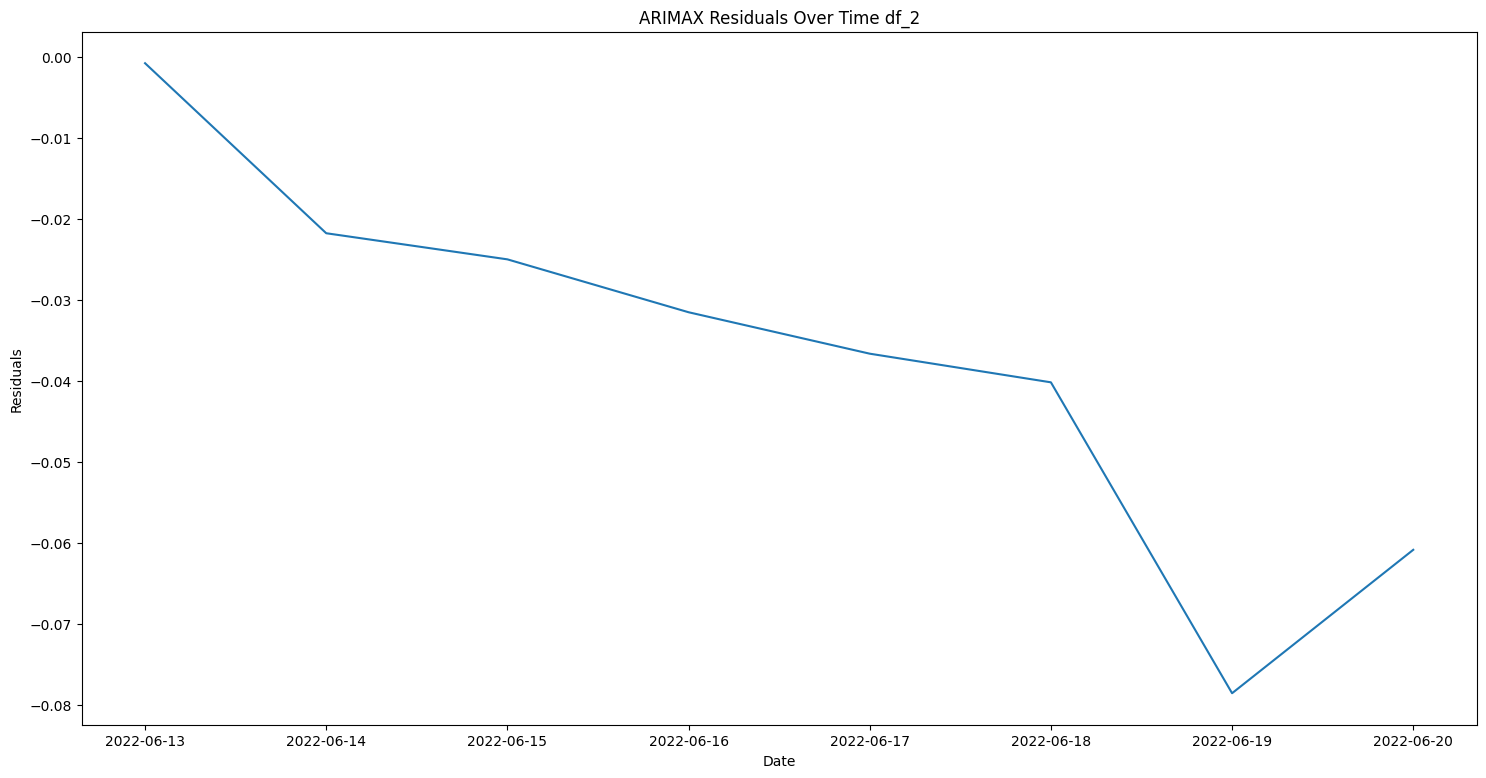

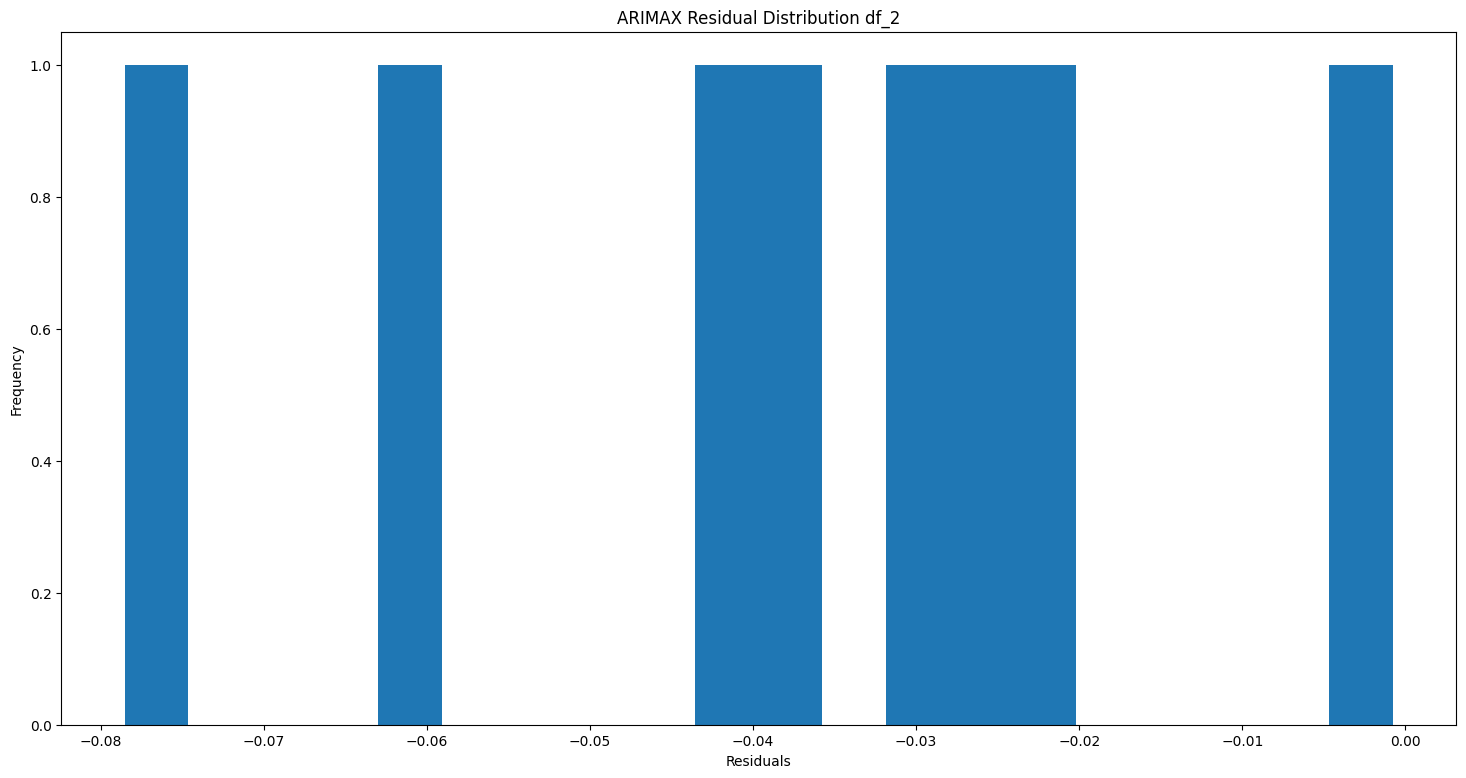

<Figure size 1800x900 with 0 Axes>

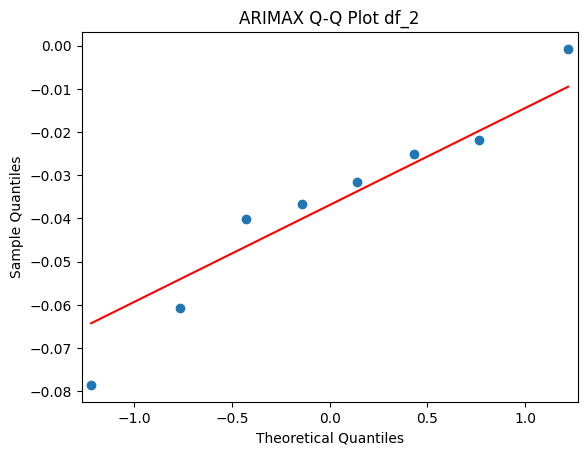

     lb_stat  lb_pvalue
1   2.616124   0.105783
2   2.878650   0.237088
3   2.883633   0.409917
4   3.429681   0.488651
5   5.189812   0.393157
6  13.802132   0.031926


In [ ]:
#ensuring same index
x_train_2 = x_train_2.set_index(y_train_2.index)

final_model_arimax_2 = ARIMA(y_train_2, exog=x_train_2, order=(0, 1, 0))
final_model_arimax_2_fit = final_model_arimax_2.fit()

y_pred_arimax_2 = final_model_arimax_2_fit.predict(
    start=y_refit_2.index[0],
    end=y_refit_2.index[-1],
    exog=x_refit_2
    )
y_pred_arimax_2.index = y_refit_2.index

#evaluating
print("MAE:", round(mae_calc(y_refit_2, y_pred_arimax_2), 4))
print("RMSE:", round(rmse_calc(y_refit_2, y_pred_arimax_2), 4))
print("SMAPE:", round(smape_calc(y_refit_2, y_pred_arimax_2), 4))

plt.figure(figsize=(18,9))
plt.plot(y_refit_2.index, y_refit_2, 'g-', label='Test Actual')
plt.plot(y_refit_2.index, y_pred_arimax_2, 'b--', label='Test Predicted')
plt.title('ARIMAX Predictions vs Actual df_2')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#residuals
residuals_2 = y_refit_2 - y_pred_arimax_2
plt.figure(figsize=(18,9))
plt.plot(residuals_2)
plt.title('ARIMAX Residuals Over Time df_2')
plt.xlabel('Date')
plt.ylabel('Residuals')

#distribution
plt.figure(figsize=(18,9))
plt.hist(residuals_2, bins=20)
plt.title('ARIMAX Residual Distribution df_2')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#qq-plot
plt.figure(figsize=(18,9))
sm.qqplot(residuals_2, line='s')
plt.title('ARIMAX Q-Q Plot df_2')
plt.show()

#residual check
lb_test_2 = acorr_ljungbox(residuals_2, lags=min(10, len(residuals_2)-2), return_df=True)
print(lb_test_2)

#save
refit_results__arimax_2 ={
    'model_name': 'ARIMAX',
    'order': (0, 1,0),
    'eval_metrics':{
        'mae': round(mae_calc(y_refit_2, y_pred_arimax_2), 4),
        'rmse': round(rmse_calc(y_refit_2, y_pred_arimax_2), 4),
        'smape': round(smape_calc(y_refit_2, y_pred_arimax_2), 4)
    },
    'ljung_bix': lb_test_2.to_dict(),
    'model': final_model_arimax_2_fit
}

#save both
model_filename_2 = 'refit_results_arimax_2.pkl'
with open(model_filename_2, 'wb') as f:
    joblib.dump(refit_results__arimax_2, f)

model_filename_2_1 = 'final_model_arimax_2.pkl'
with open(model_filename_2_1, 'wb') as f:
    joblib.dump(final_model_arimax_2_fit, f)


In [ ]:
#save everything as zip file
tracker.stop()
#saving everything created into zip file, including model, results and images and emmisions
with zipfile.ZipFile('results_arima_arimax.zip', 'w') as zipf:
    zipf.write('refit_results_arima_1.pkl')
    zipf.write('refit_results_arima_2.pkl')
    zipf.write('refit_results_arimax_1.pkl')
    zipf.write('refit_results_arimax_2.pkl')
    zipf.write('final_model_arima_1.pkl')
    zipf.write('final_model_arima_2.pkl')
    zipf.write('final_model_arimax_1.pkl')
    zipf.write('final_model_arimax_2.pkl')


[codecarbon INFO @ 13:36:45] Energy consumed for RAM : 0.002084 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:36:45] Delta energy consumed for CPU with constant : 0.000005 kWh, power : 42.5 W
[codecarbon INFO @ 13:36:45] Energy consumed for All CPU : 0.008859 kWh
[codecarbon INFO @ 13:36:45] 0.010943 kWh of electricity used since the beginning.


In [ ]:
#download
files.download('results_arima_arimax.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('emissions_arima.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Notes
The results from the Q-Q and Ljung-Box Test indicate, that particularly for Dataset 1, autocorrelation may still be present, likely due to some long term indicators in the data.